# **Required Libraries & Configurations**

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import layers, models

2026-02-14 06:25:51.463164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771050351.661648      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771050351.720783      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771050352.192957      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771050352.193001      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771050352.193004      55 computation_placer.cc:177] computation placer alr

In [2]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 200

# **Dataset Preparation**

In [3]:
DATASET_PATH = "/kaggle/input/teeth-dataset/Teeth_Dataset"

TRAIN_DIR = f"{DATASET_PATH}/Training"
VAL_DIR   = f"{DATASET_PATH}/Validation"
TEST_DIR  = f"{DATASET_PATH}/Testing"

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 3087 files belonging to 7 classes.


I0000 00:00:1771050367.688218      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771050367.694198      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


# **Visualizations**

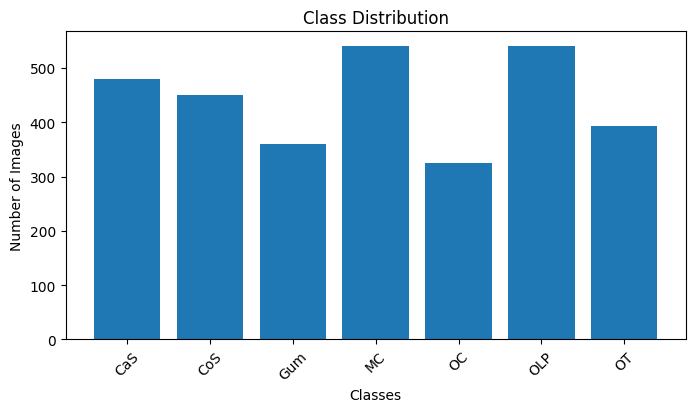

In [5]:
def plot_class_distribution(dataset, class_names):
    counts = np.zeros(len(class_names))
    for _, labels in dataset:
        counts += labels.numpy().sum(axis=0)

    plt.figure(figsize=(8, 4))
    plt.bar(class_names, counts)
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_ds, class_names)

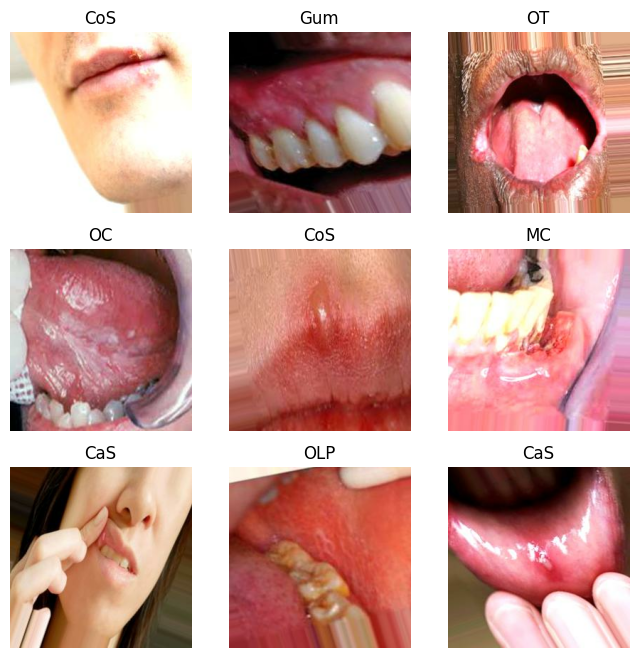

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

# **Augmentation**

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2),
    layers.Rescaling(1./255),
])

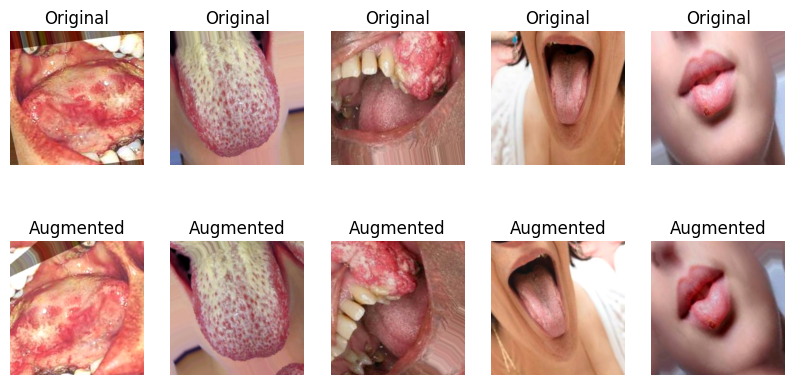

In [8]:
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)

    plt.figure(figsize=(10, 5))
    for i in range(5):
        # Original
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        # Augmented
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(augmented_images[i].numpy())
        plt.title("Augmented")
        plt.axis("off")

    plt.show()

# **CNN From Scratch**

In [9]:
# ==============================
# Custom CNN Model (From Scratch)
# ==============================

inputs = tf.keras.Input(shape=(256, 256, 3))

x = data_augmentation(inputs)

# Block 1
x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 2
x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 3
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 4
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Classification Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,927 (1.75 MB)

 Trainable params: 456,967 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/200


I0000 00:00:1771050381.157285     128 cuda_dnn.cc:529] Loaded cuDNN version 91002


49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 330ms/step - accuracy: 0.2053 - loss: 2.1897 - val_accuracy: 0.1449 - val_loss: 1.9707
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - accuracy: 0.3011 - loss: 1.8573 - val_accuracy: 0.1449 - val_loss: 2.3704
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.3136 - loss: 1.7895 - val_accuracy: 0.1449 - val_loss: 3.2570
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - accuracy: 0.3304 - loss: 1.6897 - val_accuracy: 0.1449 - val_loss: 4.1665
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.3294 - loss: 1.6988 - val_accuracy: 0.1449 - val_loss: 5.0220
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - accuracy: 0.3655 - loss: 1.6420 - val_accuracy: 0.1449 - val_loss: 5.5885
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.3681 - loss: 1.6297 - val_accuracy: 0.1449 - val_loss: 5.4236
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.3812 - loss: 1.6095 - val_accuracy

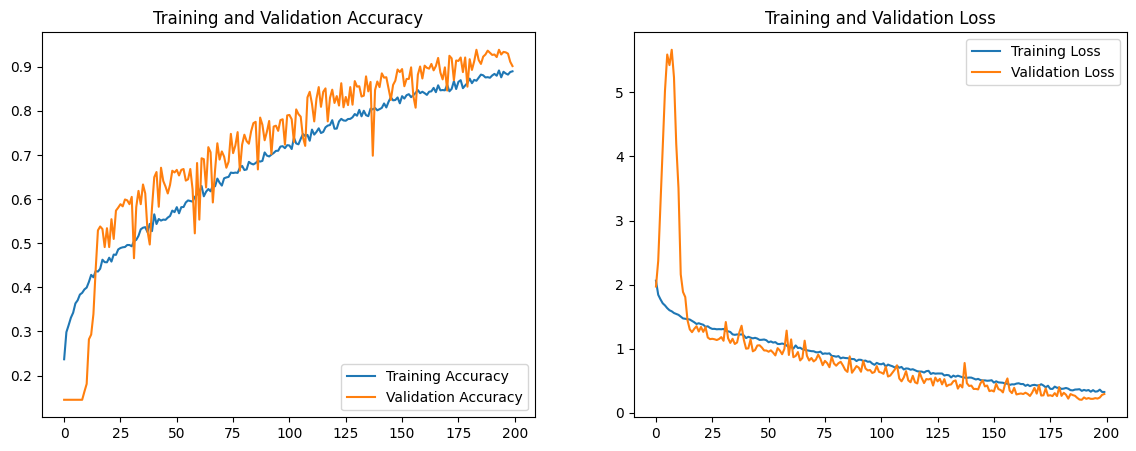

In [14]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

In [21]:
model.save("cnn_model.keras")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


<Figure size 800x800 with 0 Axes>

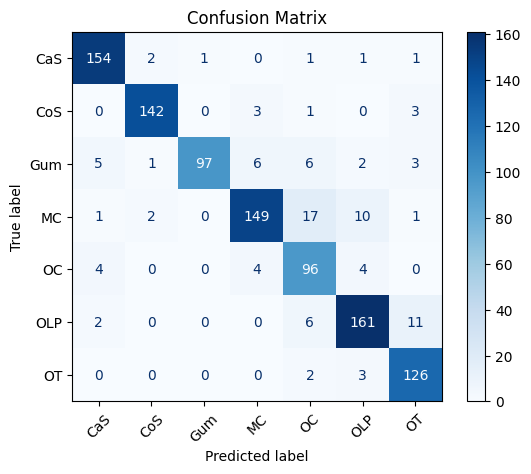

In [15]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(8, 8))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

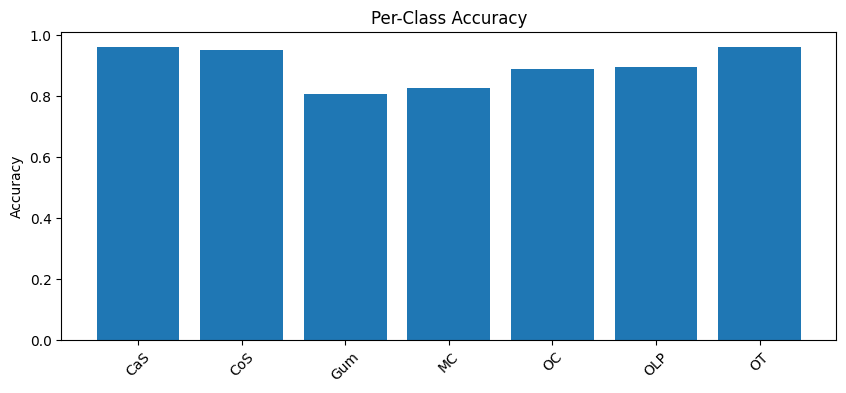

In [16]:
class_correct = np.zeros(len(class_names))
class_total = np.zeros(len(class_names))

for i in range(len(y_true)):
    label = y_true[i]
    class_total[label] += 1
    if y_true[i] == y_pred[i]:
        class_correct[label] += 1

plt.figure(figsize=(10, 4))
plt.bar(
    class_names,
    class_correct / class_total
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


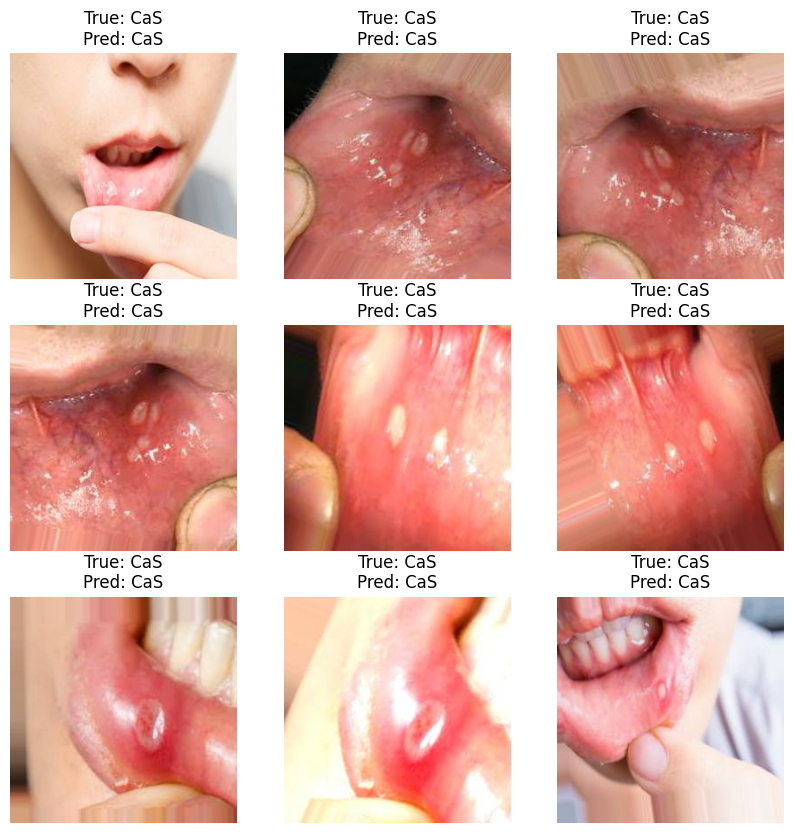

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[np.argmax(labels[i])]
        pred_label = class_names[np.argmax(preds[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9140 - loss: 0.2452
Test Loss     : 0.2934
Test Accuracy : 0.8998


In [19]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
              precision    recall  f1-score   support

         CaS       0.93      0.96      0.94       160
         CoS       0.97      0.95      0.96       149
         Gum       0.99      0.81      0.89       120
          MC       0.92      0.83      0.87       180
          OC       0.74      0.89      0.81       108
         OLP       0.89      

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


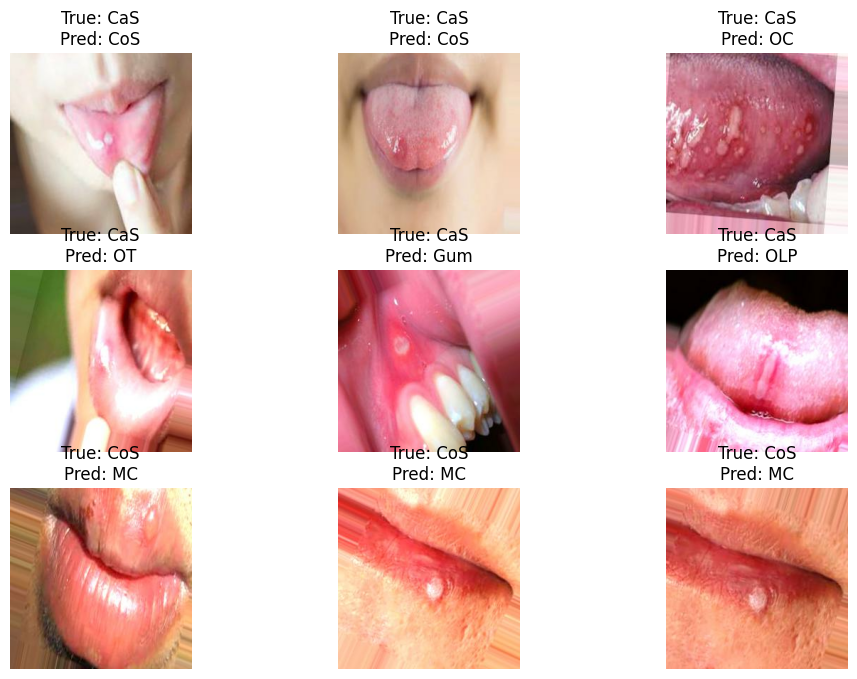

In [20]:
plt.figure(figsize=(12, 8))
shown = 0

for images, labels in test_ds:
    preds = model.predict(images)
    for i in range(len(images)):
        true = np.argmax(labels[i])
        pred = np.argmax(preds[i])
        if true != pred and shown < 9:
            plt.subplot(3, 3, shown + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
            plt.axis("off")
            shown += 1
    if shown >= 9:
        break

plt.show()